# Import dependencies

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from pathlib import Path

device = torch.device("cpu")

In [25]:
n_qubits = 4
n_layers = 1
n_depth = 2

dev = qml.device("lightning.qubit", wires=n_qubits)

def L(w):
    # (n_layers, n_qubits, 2)
    for l in range(n_layers):
        qml.AngleEmbedding(w[l, :, 0], wires=range(n_qubits), rotation="X")
        qml.AngleEmbedding(w[l, :, 1], wires=range(n_qubits), rotation="Z")
        for j in range(n_qubits):
            qml.CNOT(wires=[j, (j+1) % n_qubits])

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    L(weights[0])
    
    for d in range(n_depth):
        for i in range(n_qubits):
            qml.RX(inputs[0], wires=i)
        L(weights[d+1])
    
    return [qml.expval(qml.PauliZ(0))]

weight_shapes = {"weights": (n_depth + 1, n_layers, n_qubits, 2)}

# Approximating with quantum circuits

In [46]:
n_qubits = 1
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2],
            wires=range(n_qubits))
    qml.RX(inputs[0], wires=range(n_qubits))
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2],
            wires=range(n_qubits))
    qml.RX(inputs[0], wires=range(n_qubits))
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2],
            wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (2, 3)}

In [107]:
n_qubits = 4
n_layers = 1
n_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    qml.BasicEntanglerLayers(weights[0], wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RX(inputs[0], wires=i)
    qml.BasicEntanglerLayers(weights[0], wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_depth, n_layers, n_qubits)}

In [20]:
n_qubits = 4
n_layers = 1
n_depth = 1 + 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    
    qml.StronglyEntanglingLayers(weights[0], wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RX(inputs[0], wires=i)
    qml.StronglyEntanglingLayers(weights[1], wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_depth, n_layers, n_qubits, 3)}

In [4]:
print(qml.draw(circuit, expansion_strategy="device")(inputs=torch.ones(1), weights=torch.rand(weight_shapes["weights"])))

0: ──Rot(0.29,0.87,0.14)─╭●───────╭X──RX(1.00)──Rot(0.19,0.14,0.87)─╭●───────╭X─┤  <Z>
1: ──Rot(0.09,0.15,0.41)─╰X─╭●────│───RX(1.00)──Rot(0.57,0.19,0.59)─╰X─╭●────│──┤     
2: ──Rot(0.31,0.53,0.69)────╰X─╭●─│───RX(1.00)──Rot(0.09,0.79,0.71)────╰X─╭●─│──┤     
3: ──Rot(0.84,0.50,0.74)───────╰X─╰●──RX(1.00)──Rot(0.75,0.38,0.43)───────╰X─╰●─┤     


In [5]:
w = 2

In [119]:
f = lambda x: 0.8*torch.sin(w*x)

In [6]:
f = lambda x: torch.exp(-0.3*x) * (0.1 + 0.3*torch.cos(3*x) - 0.3*torch.sin(x))

In [162]:
f = lambda x: torch.exp(-0.3*x) * 0.5*torch.sin(2*x) 

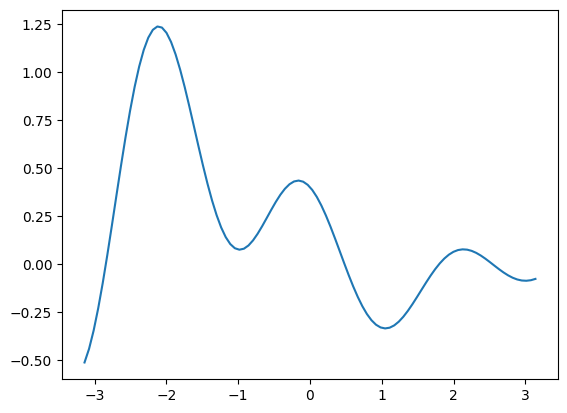

In [7]:
x = torch.linspace(-torch.pi, torch.pi, 100)
plt.plot(x, f(x))

# Models

In [8]:
from torch import nn
class ParNet(torch.nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        
        self.encoding = nn.Linear(1, 2)
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.clayer = nn.Sequential(nn.Linear(1, 20),
                                    nn.ReLU(),
                                    nn.Linear(20, 20),
                                    nn.ReLU(),
                                    nn.Linear(20, 1))
        self.decoding = nn.Linear(2, 1)
        
    def forward(self, x):
        
        x = self.encoding(x)
        x_q = self.qlayer(x[:, 0:1]).view(-1, 1)
        x_c = self.clayer(x[:, 1:2]).view(-1, 1)
        x = torch.hstack([x_q, x_c])
        
        return self.decoding(x)

In [9]:
from torch import nn
class ParNetForce(torch.nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        
        # self.encoding = nn.Linear(1, 2)
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.clayer = nn.Sequential(nn.Linear(1, 10),
                                    nn.ReLU(),
                                    nn.Linear(10, 10),
                                    nn.ReLU(),
                                    nn.Linear(10, 1))
        # self.decoding = nn.Linear(2, 1)
        
    def forward(self, x):
        
        x_q = torch.clone(x)
        x_c = torch.clone(x)
        
        x_q = self.qlayer(x_q).view(-1, 1)
        x_c = self.clayer(x_c).view(-1, 1)
        
        return x_q * x_c

In [10]:
class ClassicNet(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.seq = nn.Sequential(nn.Linear(1, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, 1))
        
    def forward(self, x):
        return self.seq(x)

In [11]:
class FreqNet(torch.nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        # self.enc = torch.nn.Linear(1, 1, bias=False)
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        # self.dec = torch.nn.Linear(1, 1, bias=False)
        
    def forward(self, x):
        # x = w * x
        # x = self.enc(x)
        x = self.qlayer(x).view(-1, 1)
        # x = self.dec(x)
        
        return x

# Train

In [12]:
def plot(qlayer, f):
    x = torch.linspace(-torch.pi, torch.pi, 100)
    y_exact = f(x)
    with torch.no_grad():
        y_pred = qlayer(x.view(-1, 1)).flatten()
    
    plt.figure()
    plt.plot(x, y_exact, label="exact")
    plt.plot(x, y_pred, label="pred")
    
    plt.legend()
    plt.show()

def fit(qlayer, f, epochs=100):

    criterion = torch.nn.MSELoss()
    optim = torch.optim.Adam(qlayer.parameters(), lr=0.01)
    
    x = torch.linspace(-torch.pi, torch.pi, 100)
    y_exact = f(x)
    
    for e in range(epochs):
        y_pred = qlayer(x.view(-1, 1)).flatten()
        loss = criterion(y_pred, y_exact)
        if e % 10 == 0:
            print(f"epoch: {e}, loss: {loss}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [13]:
net = ClassicNet(20)

In [14]:
fit(net, f)

epoch: 0, loss: 0.3135891854763031
epoch: 10, loss: 0.1279304176568985
epoch: 20, loss: 0.11064264923334122
epoch: 30, loss: 0.10264726728200912
epoch: 40, loss: 0.09306958317756653
epoch: 50, loss: 0.08413027971982956
epoch: 60, loss: 0.07147202640771866
epoch: 70, loss: 0.05606422945857048
epoch: 80, loss: 0.039140649139881134
epoch: 90, loss: 0.023381846025586128


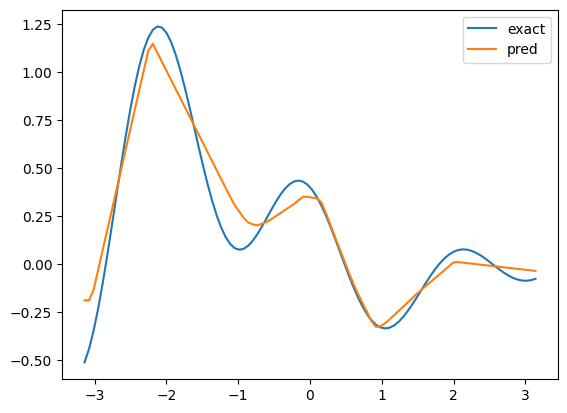

In [15]:
plot(net, f)

In [16]:
net = ParNetForce(circuit, weight_shapes)

In [17]:
fit(net, f)

/home/lurker/miniconda3/envs/qml_gpu/lib/python3.9/site-packages/pennylane/tape/qscript.py:569: UserWarning: The get_operation will soon be updated to also return the index of the trainable operation in the tape. If you want to switch to the new behavior, you can pass `return_op_index=True`
  warnings.warn(


epoch: 0, loss: 0.21172215044498444
epoch: 10, loss: 0.12434319406747818
epoch: 20, loss: 0.030085323378443718
epoch: 30, loss: 0.01408356986939907
epoch: 40, loss: 0.008649108000099659
epoch: 50, loss: 0.008377354592084885
epoch: 60, loss: 0.007061098236590624
epoch: 70, loss: 0.0060873739421367645
epoch: 80, loss: 0.00524388300254941
epoch: 90, loss: 0.004256384912878275


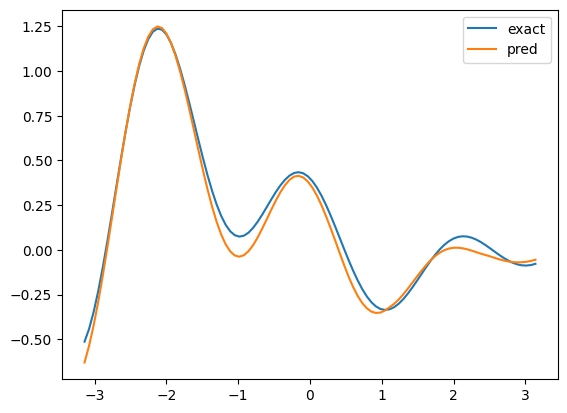

In [18]:
plot(net, f)